In [9]:
import fmpy
import shutil
import numpy as np

#fmpy.dump(fmu)  # get information
#res = fmpy.simulate_fmu(fmu)


In [10]:
# define the model name and simulation parameters
fmu_filename = 'plant.fmu'
start_time = 0.0
#threshold = 2.0
stop_time = 20.0
step_size = 0.1

# read the model description
model_description = fmpy.read_model_description(fmu_filename)

#collect the value reference
vrs = {}
for variable in model_description.modelVariables:
    vrs[variable.name] = variable.valueReference

# get the value references for the variables we want to get/set
vr_servoventil = vrs['servoventil']
vr_schaltventil1 = vrs['schaltventil1']
vr_schaltventil2 = vrs['schaltventil2']
vr_position = vrs['position']

# extract the FMU
unzipdir = fmpy.extract(fmu_filename)


In [11]:

fmu = fmpy.fmi2.FMU2Slave(guid=model_description.guid,
                    unzipDirectory=unzipdir,
                    modelIdentifier=model_description.coSimulation.modelIdentifier,
                    instanceName='instance1')

# initialize
fmu.instantiate()
fmu.setupExperiment(startTime=start_time)
fmu.enterInitializationMode()
fmu.exitInitializationMode()
time  = start_time
rows = []

# simulation loop


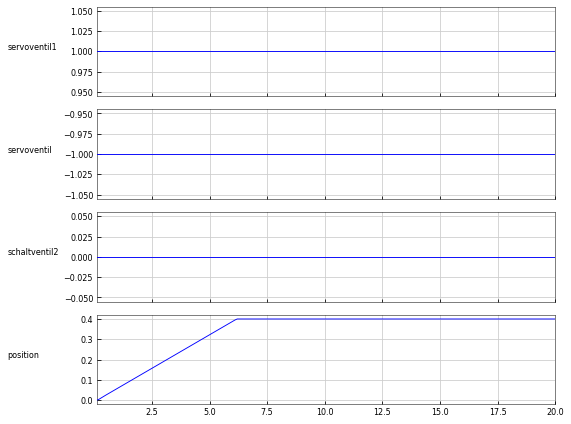

In [12]:
while time<stop_time:
    # NOTE: the FMU.get*() and FMU.set*() functions take lists of
    # value references as arguments and return lists of values

    # set the input
    fmu.setReal([vr_servoventil,vr_schaltventil1,vr_schaltventil2],[-1,1,0])

    # perform one step
    fmu.doStep(currentCommunicationPoint=time, communicationStepSize=step_size)

    # advance the time
    time += step_size

    # get the values for 'inputs' and 'outputs[4]'
    schaltventil1, servoventil, schaltventil2, position = fmu.getReal([vr_schaltventil1,vr_servoventil,vr_schaltventil2,vr_position])

    # append the results
    rows.append((time, schaltventil1, servoventil,schaltventil2,position))

    # use the threshold to terminate the simulation
    '''if outputs4 > threshold:
        print("Threshold reached at t = %g s" % time)
        break'''

fmu.terminate()
fmu.freeInstance()

# clean up
shutil.rmtree(unzipdir, ignore_errors=True)

# convert the results to a structured NumPy array
result = np.array(rows, dtype=np.dtype([('time', np.float64),
                                        ('servoventil1', np.float64), ('servoventil', np.float64), ('schaltventil2', np.float64),
                                        ('position', np.float64)]))

# plot the results
#if show_plot:
    #plot_result(result)

#return time
fmpy.util.plot_result(result)
